**129L Section 9A** <br>
3/4/25

In [33]:
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
import cv2
import os

# Task 1: Black Body Radiation

Original function: 
$$W = \frac{2 \pi k_B^4 T^4}{c^2 h^3} \int_{0}^{\infty} \frac{x^3}{e^x - 1} dx$$

**A)**

Use substitution $x = \frac{u}{1-u}$, $dx = \frac{du}{(1-u)^2}$

In [28]:
def black_body_integral():
    # Define the integrand with change of variable
    def integrand(u):
        if u == 1:
            return 0  # Avoid division by zero
        x = u / (1 - u)
        if x > 100:  # Prevent overflow in exp(x)
            return (x**3 * np.exp(-x)) * (1 / (1 - u)**2)
        return (x**3 / (np.exp(x) - 1)) * (1 / (1 - u)**2)
    
    # Perform numerical integration from 0 to 1
    result, error = integrate.quad(integrand, 0, 1)
    return result

# Compute the integral value
integral_value = black_body_integral()
print(f"Evaluated integral: {integral_value}")

Evaluated integral: 6.493939402266829


**B)**

In [23]:
# Modify the integral function to use fixed_quad

def black_body_integral_fixed_quad():
    # Define the integrand with change of variable
    def integrand(u):
        x = u / (1 - u)
        safe_exp = np.exp(np.minimum(x, 100))  # Prevent overflow
        result = np.where(x > 100, (x**3 * np.exp(-x)) * (1 / (1 - u)**2), (x**3 / (safe_exp - 1)) * (1 / (1 - u)**2))
        return result
    
    # Perform numerical integration using fixed quad
    result = integrate.fixed_quad(integrand, 0, 1, n=100)[0]
    return result


# define constants
k = 1.38064852e-23 # Boltzmann constant in J/K
h = 6.626e-34 # Planck constant in J*s
c = 3e8 # Speed of light in m/s
hbar = h / (2 * np.pi) # Reduced Planck constant
prefactor = k**4/(c**2 * hbar**3*4*np.pi**2)

integral_value = black_body_integral_fixed_quad()
sigma_fixed_quad = integral_value*prefactor

print(f"Stefan-Boltzmann constant: {sigma_fixed_quad} W/(m^2 K^4)")

Stefan-Boltzmann constant: 5.662703503454055e-08 W/(m^2 K^4)


**C)**

In [27]:
def black_body_integral_quad():
    # Define the integrand directly from 0 to infinity
    def integrand(x):
        safe_exp = np.exp(np.minimum(x, 100))  # Prevent overflow
        return np.where(x > 100, x**3 * np.exp(-x), x**3 / (safe_exp - 1))
    
    # Perform numerical integration using quad
    result, error = integrate.quad(integrand, 0, np.inf)
    return result

sigma_quad = black_body_integral_quad()*prefactor

print(f"Stefan-Boltzmann constant (fixed_quad): {sigma_fixed_quad} W/(m^2 K^4)")
print(f"Stefan-Boltzmann constant (quad):       {sigma_quad} W/(m^2 K^4)")

Stefan-Boltzmann constant (fixed_quad): 5.662703503454055e-08 W/(m^2 K^4)
Stefan-Boltzmann constant (quad):       5.662703503454045e-08 W/(m^2 K^4)


# Task 2: Orbits

**A)**

**B)**

# Task 3: Gradient Descent, Metropolis-Hastings Algorithm, Simulated Annealing

**A)**

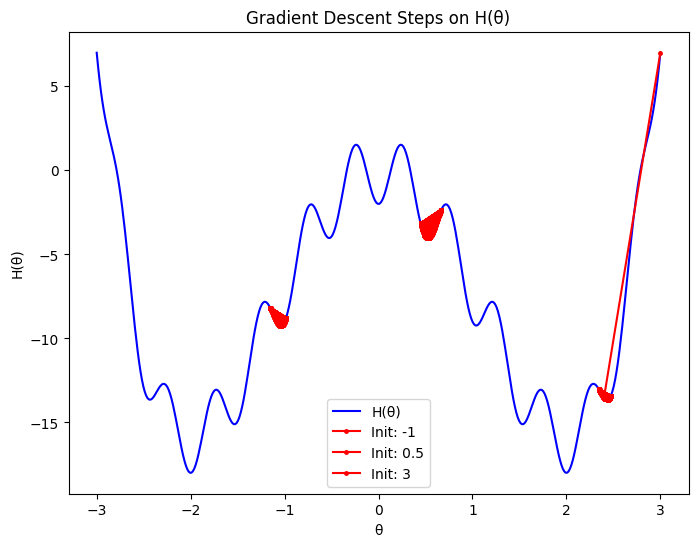

In [30]:
def H(theta):
    return theta**4 - 8*theta**2 - 2*np.cos(4*np.pi*theta)

def dH_dtheta(theta):
    return 4*theta**3 - 16*theta + 8*np.pi*np.sin(4*np.pi*theta)

def gradient_descent(theta0, alpha=0.01, tol=1e-6, max_iter=1000):
    theta = theta0
    trajectory = [theta]
    
    for _ in range(max_iter):
        grad = dH_dtheta(theta)
        theta_new = theta - alpha * grad
        trajectory.append(theta_new)
        
        if abs(theta_new - theta) < tol:
            break
        
        theta = theta_new
    
    return np.array(trajectory)

# Initial guesses
initial_guesses = [-1, 0.5, 3]
theta_range = np.linspace(-3, 3, 400)
H_values = H(theta_range)

plt.figure(figsize=(8, 6))
plt.plot(theta_range, H_values, 'b', label='H(θ)')

for theta0 in initial_guesses:
    trajectory = gradient_descent(theta0)
    plt.plot(trajectory, H(trajectory), 'r.-', markersize=5, label=f'Init: {theta0}')
    
plt.xlabel('θ')
plt.ylabel('H(θ)')
plt.legend()
plt.title('Gradient Descent Steps on H(θ)')
plt.savefig('gradient_descent_phi4.png')
plt.show()

KeyboardInterrupt: 

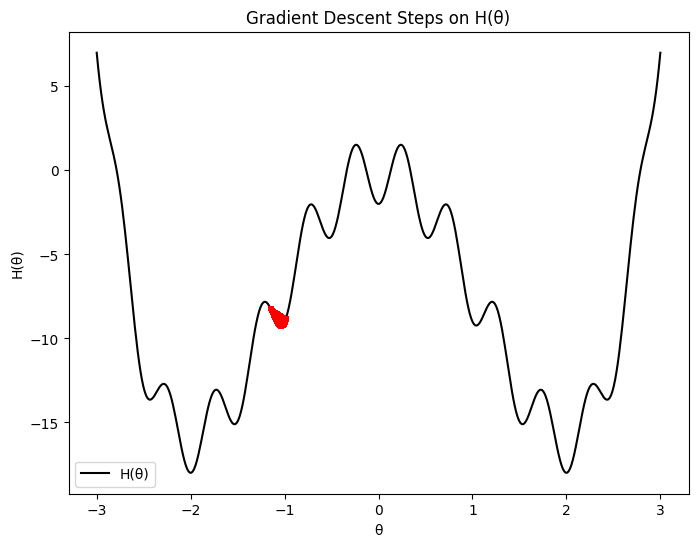

In [ ]:
# Create a directory for frames
os.makedirs("frames", exist_ok=True)

plt.figure(figsize=(8, 6))
plt.plot(theta_range, H_values, 'k', label='H(θ)')

frame_count = 0
for theta0 in initial_guesses:
    trajectory = gradient_descent(theta0)
    for step, theta in enumerate(trajectory):
        plt.plot(trajectory[:step+1], H(trajectory[:step+1]), 'r.-', markersize=5)
        plt.xlabel('θ')
        plt.ylabel('H(θ)')
        plt.legend()
        plt.title('Gradient Descent Steps on H(θ)')
        frame_path = f"frames/frame_{frame_count:04d}.png"
        plt.savefig(frame_path)
        frame_count += 1

In [37]:
# Create video from saved frames
frame_files = sorted(os.listdir("frames"))
frame_size = (800, 600)
video = cv2.VideoWriter("gradient_descent_phi4.mp4", cv2.VideoWriter_fourcc(*"mp4v"), 10, frame_size)

for frame_file in frame_files:
    frame = cv2.imread(os.path.join("frames", frame_file))
    frame = cv2.resize(frame, frame_size)
    video.write(frame)

video.release()
print("Video saved as gradient_descent_phi4.mp4")

Video saved as gradient_descent_phi4.mp4


**B)**

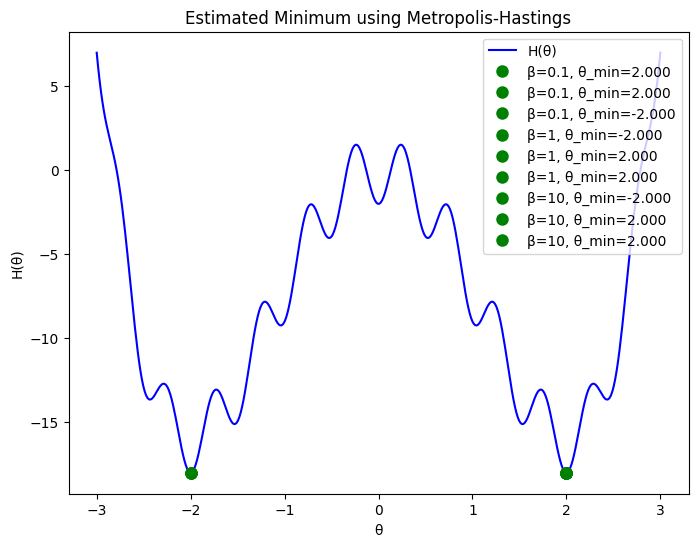

In [36]:
def metropolis_hastings(theta0, beta, steps=10000, proposal_std=0.5):
    theta = theta0
    trajectory = [theta]
    
    for _ in range(steps):
        theta_proposed = theta + np.random.normal(0, proposal_std)
        dH = H(theta_proposed) - H(theta)
        
        if dH < 0 or np.random.rand() < np.exp(-beta * dH):
            theta = theta_proposed
        
        trajectory.append(theta)
    
    return np.array(trajectory)

# Initial guesses and beta values
initial_guesses = [-1, 0.5, 3]
beta_values = [0.1, 1, 10]  # Different β values

theta_range = np.linspace(-3, 3, 400)
H_values = H(theta_range)

plt.figure(figsize=(8, 6))
plt.plot(theta_range, H_values, 'b', label='H(θ)')

for beta in beta_values:
    for theta0 in initial_guesses:
        trajectory = metropolis_hastings(theta0, beta)
        min_theta = trajectory[np.argmin(H(trajectory))]
        min_H = H(min_theta)
        plt.plot(min_theta, min_H, 'go', markersize=8, label=f'β={beta}, θ_min={min_theta:.3f}')

plt.xlabel('θ')
plt.ylabel('H(θ)')
plt.legend()
plt.title('Estimated Minimum using Metropolis-Hastings')
plt.show()

**C)**